# Fase 3: Diseño de Modelo de Datos para Business Intelligence

**Proyecto:** Análisis de Deserción Educativa en Colombia

**Objetivos de este notebook:**
1. Diseñar modelo dimensional tipo estrella
2. Crear tablas de dimensiones
3. Crear tabla de hechos
4. Definir y calcular KPIs principales
5. Preparar datos para dashboard interactivo
6. Implementar reglas de negocio

---

## 1. Importación de Librerías

In [1]:
# Manipulación de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Utilidades
import warnings
import os
from datetime import datetime

# Configuración
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Crear directorios
os.makedirs('../data/bi', exist_ok=True)
os.makedirs('../reports/figures', exist_ok=True)

print("✓ Librerías importadas exitosamente")

✓ Librerías importadas exitosamente


## 2. Carga de Datos Procesados

In [2]:
# Cargar datos limpios
df_no_academica = pd.read_csv('../data/processed/desercion_no_academica_clean.csv')
df_academica = pd.read_csv('../data/processed/desercion_academica_clean.csv')
df_sena = pd.read_csv('../data/processed/desercion_sena_clean.csv')

print("=" * 70)
print("DATOS CARGADOS PARA DISEÑO DE BI")
print("=" * 70)
print(f"Dataset No Académica: {len(df_no_academica):,} registros")
print(f"Dataset Académica: {len(df_academica):,} registros")
print(f"Dataset SENA: {len(df_sena):,} registros")
print("=" * 70)

DATOS CARGADOS PARA DISEÑO DE BI
Dataset No Académica: 1,595 registros
Dataset Académica: 3,372 registros
Dataset SENA: 42,080 registros


## 3. Definición de Reglas de Negocio

### 3.1 Reglas para Clasificación de Riesgo

In [3]:
# Definir reglas de negocio
REGLAS_NEGOCIO = {
    'tasa_desercion': {
        'bajo': (0, 10),
        'medio': (10, 20),
        'alto': (20, 30),
        'critico': (30, 100)
    },
    'edad_critica': {
        'muy_joven': (0, 18),
        'normal': (18, 25),
        'mayor': (25, 100)
    },
    'estrato_vulnerable': [1, 2],
    'modalidad_riesgo': ['VIRTUAL', 'DISTANCIA']
}

def clasificar_tasa_desercion(tasa):
    """
    Clasifica la tasa de deserción según reglas de negocio
    """
    if pd.isna(tasa):
        return 'SIN_DATOS'
    elif tasa < 10:
        return 'BAJO'
    elif tasa < 20:
        return 'MEDIO'
    elif tasa < 30:
        return 'ALTO'
    else:
        return 'CRITICO'

def calcular_score_riesgo(row):
    """
    Calcula score de riesgo de deserción (0-100)
    Basado en múltiples factores
    """
    score = 0
    
    # Factor estrato (peso: 30%)
    if 'estrato_num' in row:
        if not pd.isna(row['estrato_num']) and row['estrato_num'] in [1, 2]:
            score += 30
        elif not pd.isna(row['estrato_num']) and row['estrato_num'] in [3, 4]:
            score += 15
    
    # Factor modalidad (peso: 25%)
    if 'modalidad' in row:
        if row['modalidad'] in ['VIRTUAL', 'DISTANCIA']:
            score += 25
        elif row['modalidad'] == 'PRESENCIAL':
            score += 5
    
    # Factor edad (peso: 20%)
    if 'edad' in row and not pd.isna(row['edad']):
        if row['edad'] < 18 or row['edad'] > 30:
            score += 20
        elif row['edad'] > 25:
            score += 10
    
    # Factor jornada (peso: 15%)
    if 'jornada' in row:
        if 'NOCTURNA' in str(row['jornada']).upper():
            score += 15
        elif 'EXTENDIDA' in str(row['jornada']).upper():
            score += 10
    
    # Factor género (peso: 10% - ajustable según análisis)
    # Esto es ilustrativo, ajustar según hallazgos del EDA
    if 'genero' in row:
        if row['genero'] == 'M':
            score += 5
    
    return min(score, 100)  # Max 100

print("✓ Reglas de negocio definidas")
print("\nReglas de Clasificación:")
print(f"  • Tasa Baja: < 10%")
print(f"  • Tasa Media: 10-20%")
print(f"  • Tasa Alta: 20-30%")
print(f"  • Tasa Crítica: > 30%")

✓ Reglas de negocio definidas

Reglas de Clasificación:
  • Tasa Baja: < 10%
  • Tasa Media: 10-20%
  • Tasa Alta: 20-30%
  • Tasa Crítica: > 30%


## 4. Diseño del Modelo Dimensional - Esquema Estrella

### 4.1 Dimensión: DIM_TIEMPO

In [4]:
# Crear dimensión de tiempo
def crear_dim_tiempo(df_list):
    """
    Crea tabla de dimensión tiempo
    """
    # Combinar todos los periodos únicos
    periodos = []
    for df in df_list:
        if 'periodo' in df.columns:
            periodos.extend(df['periodo'].unique())
    
    periodos_unicos = pd.Series(periodos).dropna().unique()
    
    # Crear dataframe de dimensión
    dim_tiempo = pd.DataFrame({
        'periodo': periodos_unicos
    })
    
    # Extraer información temporal
    dim_tiempo['periodo_año'] = dim_tiempo['periodo'].str.extract(r'(\d{4})')[0].astype(float)
    dim_tiempo['periodo_semestre'] = dim_tiempo['periodo'].str.contains('PRIMER', case=False).map({True: 1, False: 2})
    dim_tiempo['periodo_completo'] = dim_tiempo['periodo_año'].astype(str) + '-S' + dim_tiempo['periodo_semestre'].astype(str)
    
    # ID único
    dim_tiempo['id_tiempo'] = range(1, len(dim_tiempo) + 1)
    
    # Reordenar columnas
    dim_tiempo = dim_tiempo[['id_tiempo', 'periodo', 'periodo_año', 'periodo_semestre', 'periodo_completo']]
    
    return dim_tiempo.sort_values(['periodo_año', 'periodo_semestre'])

# Crear dimensión
dim_tiempo = crear_dim_tiempo([df_no_academica, df_academica, df_sena])

print("=" * 70)
print("DIMENSIÓN TIEMPO CREADA")
print("=" * 70)
print(f"Registros: {len(dim_tiempo)}")
print(f"\nPrimeros registros:")
print(dim_tiempo.head(10))
print(f"\nÚltimos registros:")
print(dim_tiempo.tail(5))

DIMENSIÓN TIEMPO CREADA
Registros: 22

Primeros registros:
    id_tiempo                   periodo  periodo_año  periodo_semestre  \
0           1      PRIMER SEMESTRE 2020       2020.0                 1   
1           2     SEGUNDO SEMESTRE 2020       2020.0                 2   
11         12  SEGUNDO SEMESTRE DE 2020       2020.0                 2   
3           4      PRIMER SEMESTRE 2021       2021.0                 1   
12         13  PRIMER  SEMESTRE DE 2021       2021.0                 1   
4           5     SEGUNDO SEMESTRE 2021       2021.0                 2   
13         14  SEGUNDO SEMESTRE DE 2021       2021.0                 2   
5           6      PRIMER SEMESTRE 2022       2022.0                 1   
14         15   PRIMER SEMESTRE DE 2022       2022.0                 1   
6           7     SEGUNDO SEMESTRE 2022       2022.0                 2   

   periodo_completo  
0         2020.0-S1  
1         2020.0-S2  
11        2020.0-S2  
3         2021.0-S1  
12        2021.0

### 4.2 Dimensión: DIM_ESTUDIANTE

In [5]:
# Crear dimensión de estudiante (del dataset académico que tiene info individual)
def crear_dim_estudiante(df_academica):
    """
    Crea tabla de dimensión estudiante
    """
    dim_estudiante = df_academica[[
        'tipo_iden_est', 'genero', 'edad', 'estrato', 
        'estrato_num', 'origen_geografico', 'lugar_expedicion'
    ]].copy()
    
    # Añadir grupo de edad
    if 'grupo_edad' in df_academica.columns:
        dim_estudiante['grupo_edad'] = df_academica['grupo_edad']
    else:
        dim_estudiante['grupo_edad'] = pd.cut(
            dim_estudiante['edad'],
            bins=[0, 20, 25, 30, 100],
            labels=['16-20', '21-25', '26-30', '31+']
        )
    
    # Añadir grupo de estrato
    if 'grupo_estrato' in df_academica.columns:
        dim_estudiante['grupo_estrato'] = df_academica['grupo_estrato']
    else:
        dim_estudiante['grupo_estrato'] = pd.cut(
            dim_estudiante['estrato_num'],
            bins=[0, 2, 4, 6],
            labels=['BAJO', 'MEDIO', 'ALTO'],
            include_lowest=True
        )
    
    # Extraer departamento del origen geográfico
    dim_estudiante['departamento'] = dim_estudiante['origen_geografico'].str.split().str[0]
    
    # ID único
    dim_estudiante['id_estudiante'] = range(1, len(dim_estudiante) + 1)
    
    # Reordenar
    dim_estudiante = dim_estudiante[[
        'id_estudiante', 'tipo_iden_est', 'edad', 'grupo_edad',
        'genero', 'estrato', 'estrato_num', 'grupo_estrato',
        'origen_geografico', 'departamento', 'lugar_expedicion'
    ]]
    
    return dim_estudiante

# Crear dimensión
dim_estudiante = crear_dim_estudiante(df_academica)

print("=" * 70)
print("DIMENSIÓN ESTUDIANTE CREADA")
print("=" * 70)
print(f"Registros: {len(dim_estudiante)}")
print(f"\nPrimeros registros:")
print(dim_estudiante.head())
print(f"\nDistribución por grupo de edad:")
print(dim_estudiante['grupo_edad'].value_counts())
print(f"\nDistribución por grupo de estrato:")
print(dim_estudiante['grupo_estrato'].value_counts())

DIMENSIÓN ESTUDIANTE CREADA
Registros: 3372

Primeros registros:
   id_estudiante tipo_iden_est  edad grupo_edad genero          estrato  \
0              1          C.C.    65        31+      M  SIN INFORMACIÓN   
1              2          C.C.    47        31+      F  SIN INFORMACIÓN   
2              3          C.C.    46        31+      F  SIN INFORMACIÓN   
3              4          C.C.    27      26-30      M  SIN INFORMACIÓN   
4              5          C.C.    35        31+      F  SIN INFORMACIÓN   

   estrato_num grupo_estrato origen_geografico departamento lugar_expedicion  
0          NaN           NaN             TUNJA        TUNJA            TUNJA  
1          NaN           NaN           DUITAMA      DUITAMA          DUITAMA  
2          NaN           NaN             SOATÁ        SOATÁ            SOATÁ  
3          NaN           NaN             SOCHA        SOCHA            SOCHA  
4          NaN           NaN            CÚCUTA       CÚCUTA           CÚCUTA  

Distribuc

### 4.3 Dimensión: DIM_PROGRAMA

In [6]:
# Crear dimensión de programa académico
def crear_dim_programa(df_list):
    """
    Crea tabla de dimensión programa
    """
    # Combinar información de programas de ambos datasets UPTC
    programas_list = []
    
    for df in df_list[:2]:  # Solo UPTC
        if all(col in df.columns for col in ['nombre_programa', 'nombre_facultad', 'modalidad', 'jornada']):
            prog_df = df[['nombre_programa', 'nombre_facultad', 'modalidad', 'jornada']].copy()
            prog_df['nivel_academico'] = df.get('nivel_académico', 'PREGRADO')
            programas_list.append(prog_df)
    
    # SENA
    if 'nombre_programa_formacion' in df_list[2].columns:
        prog_sena = pd.DataFrame({
            'nombre_programa': df_list[2]['nombre_programa_formacion'],
            'nombre_facultad': df_list[2].get('nombre_centro', 'SENA'),
            'modalidad': df_list[2].get('modalidad_formacion', 'PRESENCIAL'),
            'jornada': 'COMPLETA',
            'nivel_academico': df_list[2].get('nivel_formacion', 'TECNICO')
        })
        programas_list.append(prog_sena)
    
    # Combinar
    dim_programa = pd.concat(programas_list, ignore_index=True)
    
    # Eliminar duplicados
    dim_programa = dim_programa.drop_duplicates(subset=['nombre_programa', 'nombre_facultad'])
    
    # ID único
    dim_programa['id_programa'] = range(1, len(dim_programa) + 1)
    
    # Reordenar
    dim_programa = dim_programa[[
        'id_programa', 'nombre_programa', 'nivel_academico',
        'nombre_facultad', 'modalidad', 'jornada'
    ]]
    
    return dim_programa

# Crear dimensión
dim_programa = crear_dim_programa([df_no_academica, df_academica, df_sena])

print("=" * 70)
print("DIMENSIÓN PROGRAMA CREADA")
print("=" * 70)
print(f"Registros: {len(dim_programa)}")
print(f"\nPrimeros registros:")
print(dim_programa.head(10))
print(f"\nDistribución por modalidad:")
print(dim_programa['modalidad'].value_counts())
print(f"\nTop 5 facultades:")
print(dim_programa['nombre_facultad'].value_counts().head())

DIMENSIÓN PROGRAMA CREADA
Registros: 10894

Primeros registros:
   id_programa                                    nombre_programa  \
0            1                                           BIOLOGIA   
1            2                                             FISICA   
2            3                                        MATEMATICAS   
3            4                                            QUIMICA   
4            5                              INGENIERIA AGRONOMICA   
5            6                   MEDICINA VETERINARIA Y ZOOTECNIA   
6            7                         ARTES PLÁSTICAS Y VISUALES   
7            8  LIC. EN PSICOPEDAGOGIA ENFASIS ASESORIA EDUCATIVA   
8            9  LICENCIATURA  EN CIENCIAS NATURALES Y EDUCACIO...   
9           10                  LICENCIATURA EN CIENCIAS SOCIALES   

  nivel_academico           nombre_facultad   modalidad    jornada  
0        PREGRADO                  CIENCIAS  PRESENCIAL     DIURNA  
1        PREGRADO                  CIE

### 4.4 Dimensión: DIM_INSTITUCION

In [7]:
# Crear dimensión de institución/sede
def crear_dim_institucion(df_list):
    """
    Crea tabla de dimensión institución
    """
    instituciones = []
    
    # UPTC
    for df in df_list[:2]:
        if 'nombre_sede' in df.columns:
            inst_df = pd.DataFrame({
                'nombre_institucion': 'UPTC',
                'tipo_institucion': 'UNIVERSIDAD',
                'nombre_sede': df['nombre_sede'],
                'ciudad': df['nombre_sede'],  # Simplificado
                'departamento': 'BOYACÁ'
            })
            instituciones.append(inst_df)
    
    # SENA
    if all(col in df_list[2].columns for col in ['nombre_regional', 'nombre_centro']):
        inst_sena = pd.DataFrame({
            'nombre_institucion': 'SENA',
            'tipo_institucion': 'CENTRO_FORMACION',
            'nombre_sede': df_list[2]['nombre_centro'],
            'ciudad': df_list[2]['nombre_regional'],
            'departamento': df_list[2]['nombre_regional']
        })
        instituciones.append(inst_sena)
    
    # Combinar
    dim_institucion = pd.concat(instituciones, ignore_index=True)
    dim_institucion = dim_institucion.drop_duplicates()
    
    # ID único
    dim_institucion['id_institucion'] = range(1, len(dim_institucion) + 1)
    
    # Reordenar
    dim_institucion = dim_institucion[[
        'id_institucion', 'nombre_institucion', 'tipo_institucion',
        'nombre_sede', 'ciudad', 'departamento'
    ]]
    
    return dim_institucion

# Crear dimensión
dim_institucion = crear_dim_institucion([df_no_academica, df_academica, df_sena])

print("=" * 70)
print("DIMENSIÓN INSTITUCIÓN CREADA")
print("=" * 70)
print(f"Registros: {len(dim_institucion)}")
print(f"\nPrimeros registros:")
print(dim_institucion.head(10))
print(f"\nDistribución por institución:")
print(dim_institucion['nombre_institucion'].value_counts())

DIMENSIÓN INSTITUCIÓN CREADA
Registros: 136

Primeros registros:
     id_institucion nombre_institucion tipo_institucion   nombre_sede  \
0                 1               UPTC      UNIVERSIDAD         TUNJA   
17                2               UPTC      UNIVERSIDAD       DUITAMA   
18                3               UPTC      UNIVERSIDAD      SOGAMOSO   
23                4               UPTC      UNIVERSIDAD  CHIQUINQUIRA   
198               5               UPTC      UNIVERSIDAD         SOATA   
199               6               UPTC      UNIVERSIDAD         YOPAL   
202               7               UPTC      UNIVERSIDAD         COGUA   
204               8               UPTC      UNIVERSIDAD       QUETAME   
205               9               UPTC      UNIVERSIDAD       LETICIA   
280              10               UPTC      UNIVERSIDAD       AGUAZUL   

           ciudad departamento  
0           TUNJA       BOYACÁ  
17        DUITAMA       BOYACÁ  
18       SOGAMOSO       BOYACÁ  

### 4.5 Tabla de Hechos: FACT_DESERCION

In [8]:
# Crear tabla de hechos
def crear_fact_desercion(df_academica, dim_tiempo, dim_estudiante, dim_programa, dim_institucion):
    """
    Crea tabla de hechos de deserción
    """
    fact = df_academica.copy()
    
    # Agregar IDs de dimensiones (simplificado - en producción usar JOINs apropiados)
    fact['id_hecho'] = range(1, len(fact) + 1)
    fact['id_estudiante'] = dim_estudiante['id_estudiante'].values[:len(fact)]  # Simplificado
    
    # Join con dim_tiempo basado en periodo
    fact = fact.merge(
        dim_tiempo[['id_tiempo', 'periodo']],
        on='periodo',
        how='left'
    )
    
    # Es desertor (todos son desertores en este dataset)
    fact['es_desertor'] = 1
    fact['cantidad_desertores'] = 1
    
    # Tipo de deserción
    fact['tipo_desercion'] = fact.get('tipo_desercion', 'ACADEMICA')
    
    # Calcular score de riesgo
    fact['score_riesgo'] = fact.apply(calcular_score_riesgo, axis=1)
    
    # Clasificar nivel de riesgo basado en score
    fact['nivel_riesgo'] = pd.cut(
        fact['score_riesgo'],
        bins=[0, 25, 50, 75, 100],
        labels=['BAJO', 'MEDIO', 'ALTO', 'CRITICO'],
        include_lowest=True
    )
    
    # Seleccionar columnas finales
    fact_final = fact[[
        'id_hecho', 'id_tiempo', 'id_estudiante',
        'es_desertor', 'tipo_desercion', 'cantidad_desertores',
        'score_riesgo', 'nivel_riesgo'
    ]]
    
    return fact_final

# Crear tabla de hechos
fact_desercion = crear_fact_desercion(df_academica, dim_tiempo, dim_estudiante, dim_programa, dim_institucion)

print("=" * 70)
print("TABLA DE HECHOS CREADA")
print("=" * 70)
print(f"Registros: {len(fact_desercion)}")
print(f"\nPrimeros registros:")
print(fact_desercion.head())
print(f"\nEstadísticas de Score de Riesgo:")
print(fact_desercion['score_riesgo'].describe())
print(f"\nDistribución de Nivel de Riesgo:")
print(fact_desercion['nivel_riesgo'].value_counts())

TABLA DE HECHOS CREADA
Registros: 3372

Primeros registros:
   id_hecho  id_tiempo  id_estudiante  es_desertor tipo_desercion  \
0         1          1              1            1      ACADEMICA   
1         2          1              2            1      ACADEMICA   
2         3          1              3            1      ACADEMICA   
3         4          1              4            1      ACADEMICA   
4         5          1              5            1      ACADEMICA   

   cantidad_desertores  score_riesgo nivel_riesgo  
0                    1            30        MEDIO  
1                    1            25         BAJO  
2                    1            25         BAJO  
3                    1            20         BAJO  
4                    1            25         BAJO  

Estadísticas de Score de Riesgo:
count    3372.000000
mean       48.828588
std        15.597208
min         5.000000
25%        40.000000
50%        50.000000
75%        60.000000
max        90.000000
Name: score

## 5. Definición y Cálculo de KPIs

### 5.1 KPIs Principales

In [9]:
# Calcular KPIs principales
print("=" * 70)
print("CÁLCULO DE KPIs PRINCIPALES")
print("=" * 70)

# KPI 1: Total de Desertores
kpi_total_desertores = fact_desercion['cantidad_desertores'].sum()
print(f"\n📊 KPI 1 - TOTAL DE DESERTORES: {kpi_total_desertores:,}")

# KPI 2: Score Promedio de Riesgo
kpi_score_promedio = fact_desercion['score_riesgo'].mean()
print(f"\n📊 KPI 2 - SCORE PROMEDIO DE RIESGO: {kpi_score_promedio:.2f}/100")

# KPI 3: Porcentaje en Riesgo Alto/Crítico
total_estudiantes = len(fact_desercion)
estudiantes_alto_riesgo = len(fact_desercion[fact_desercion['nivel_riesgo'].isin(['ALTO', 'CRITICO'])])
kpi_pct_alto_riesgo = (estudiantes_alto_riesgo / total_estudiantes) * 100
print(f"\n📊 KPI 3 - % EN RIESGO ALTO/CRÍTICO: {kpi_pct_alto_riesgo:.2f}%")
print(f"   ({estudiantes_alto_riesgo:,} de {total_estudiantes:,} estudiantes)")

# KPI 4: Distribución por Tipo de Deserción
print(f"\n📊 KPI 4 - DISTRIBUCIÓN POR TIPO:")
tipo_dist = fact_desercion['tipo_desercion'].value_counts()
for tipo, count in tipo_dist.items():
    pct = (count / total_estudiantes) * 100
    print(f"   • {tipo}: {count:,} ({pct:.1f}%)")

# KPI 5: Tendencia Temporal
print(f"\n📊 KPI 5 - TENDENCIA TEMPORAL:")
desercion_por_tiempo = fact_desercion.merge(
    dim_tiempo[['id_tiempo', 'periodo_año', 'periodo_semestre']],
    on='id_tiempo'
).groupby('periodo_año')['cantidad_desertores'].sum().sort_index()

if len(desercion_por_tiempo) > 1:
    año_inicial = desercion_por_tiempo.index[0]
    año_final = desercion_por_tiempo.index[-1]
    variacion = desercion_por_tiempo.iloc[-1] - desercion_por_tiempo.iloc[0]
    variacion_pct = (variacion / desercion_por_tiempo.iloc[0]) * 100
    print(f"   • De {int(año_inicial)} a {int(año_final)}: {variacion:+.0f} estudiantes ({variacion_pct:+.1f}%)")
    
    if variacion_pct > 0:
        print(f"   • ⚠️  Tendencia CRECIENTE")
    else:
        print(f"   • ✓ Tendencia DECRECIENTE")

print("\n" + "=" * 70)

CÁLCULO DE KPIs PRINCIPALES

📊 KPI 1 - TOTAL DE DESERTORES: 3,372

📊 KPI 2 - SCORE PROMEDIO DE RIESGO: 48.83/100

📊 KPI 3 - % EN RIESGO ALTO/CRÍTICO: 42.38%
   (1,429 de 3,372 estudiantes)

📊 KPI 4 - DISTRIBUCIÓN POR TIPO:
   • ACADEMICA: 3,372 (100.0%)

📊 KPI 5 - TENDENCIA TEMPORAL:
   • De 2020 a 2025: +360 estudiantes (+800.0%)
   • ⚠️  Tendencia CRECIENTE



### 5.2 KPIs por Dimensiones

In [10]:
# KPIs por grupo de edad
print("=" * 70)
print("KPIs POR GRUPO DE EDAD")
print("=" * 70)

fact_con_edad = fact_desercion.merge(
    dim_estudiante[['id_estudiante', 'grupo_edad']],
    on='id_estudiante'
)

kpi_por_edad = fact_con_edad.groupby('grupo_edad').agg({
    'cantidad_desertores': 'sum',
    'score_riesgo': 'mean'
}).round(2)

kpi_por_edad['porcentaje'] = (kpi_por_edad['cantidad_desertores'] / kpi_por_edad['cantidad_desertores'].sum() * 100).round(2)
kpi_por_edad.columns = ['Total Desertores', 'Score Riesgo Promedio', 'Porcentaje']

print(kpi_por_edad)
print("\n" + "=" * 70)

KPIs POR GRUPO DE EDAD
            Total Desertores  Score Riesgo Promedio  Porcentaje
grupo_edad                                                     
16-20                    741                  45.72       21.98
21-25                   1365                  43.94       40.48
26-30                    726                  54.00       21.53
31+                      540                  58.50       16.01



In [11]:
# KPIs por estrato
print("=" * 70)
print("KPIs POR GRUPO DE ESTRATO")
print("=" * 70)

fact_con_estrato = fact_desercion.merge(
    dim_estudiante[['id_estudiante', 'grupo_estrato']],
    on='id_estudiante'
)

kpi_por_estrato = fact_con_estrato.groupby('grupo_estrato').agg({
    'cantidad_desertores': 'sum',
    'score_riesgo': 'mean'
}).round(2)

kpi_por_estrato['porcentaje'] = (kpi_por_estrato['cantidad_desertores'] / kpi_por_estrato['cantidad_desertores'].sum() * 100).round(2)
kpi_por_estrato.columns = ['Total Desertores', 'Score Riesgo Promedio', 'Porcentaje']

print(kpi_por_estrato)
print("\n" + "=" * 70)

KPIs POR GRUPO DE ESTRATO
               Total Desertores  Score Riesgo Promedio  Porcentaje
grupo_estrato                                                     
BAJO                       2637                  53.16       86.91
MEDIO                       397                  36.84       13.09



## 6. Visualización del Modelo Dimensional

In [12]:
# Visualizar resumen del modelo estrella
print("=" * 70)
print("RESUMEN DEL MODELO DIMENSIONAL ESTRELLA")
print("=" * 70)

modelo_resumen = pd.DataFrame({
    'Tabla': [
        'FACT_DESERCION (Hechos)',
        'DIM_TIEMPO (Dimensión)',
        'DIM_ESTUDIANTE (Dimensión)',
        'DIM_PROGRAMA (Dimensión)',
        'DIM_INSTITUCION (Dimensión)'
    ],
    'Registros': [
        f"{len(fact_desercion):,}",
        f"{len(dim_tiempo):,}",
        f"{len(dim_estudiante):,}",
        f"{len(dim_programa):,}",
        f"{len(dim_institucion):,}"
    ],
    'Columnas': [
        fact_desercion.shape[1],
        dim_tiempo.shape[1],
        dim_estudiante.shape[1],
        dim_programa.shape[1],
        dim_institucion.shape[1]
    ],
    'Descripción': [
        'Tabla central con métricas de deserción',
        'Periodos académicos (año, semestre)',
        'Información demográfica de estudiantes',
        'Programas académicos y sus características',
        'Instituciones, sedes y ubicaciones'
    ]
})

print(modelo_resumen.to_string(index=False))
print("\n" + "=" * 70)

RESUMEN DEL MODELO DIMENSIONAL ESTRELLA
                      Tabla Registros  Columnas                                Descripción
    FACT_DESERCION (Hechos)     3,372         8    Tabla central con métricas de deserción
     DIM_TIEMPO (Dimensión)        22         5        Periodos académicos (año, semestre)
 DIM_ESTUDIANTE (Dimensión)     3,372        11     Información demográfica de estudiantes
   DIM_PROGRAMA (Dimensión)    10,894         6 Programas académicos y sus características
DIM_INSTITUCION (Dimensión)       136         6         Instituciones, sedes y ubicaciones



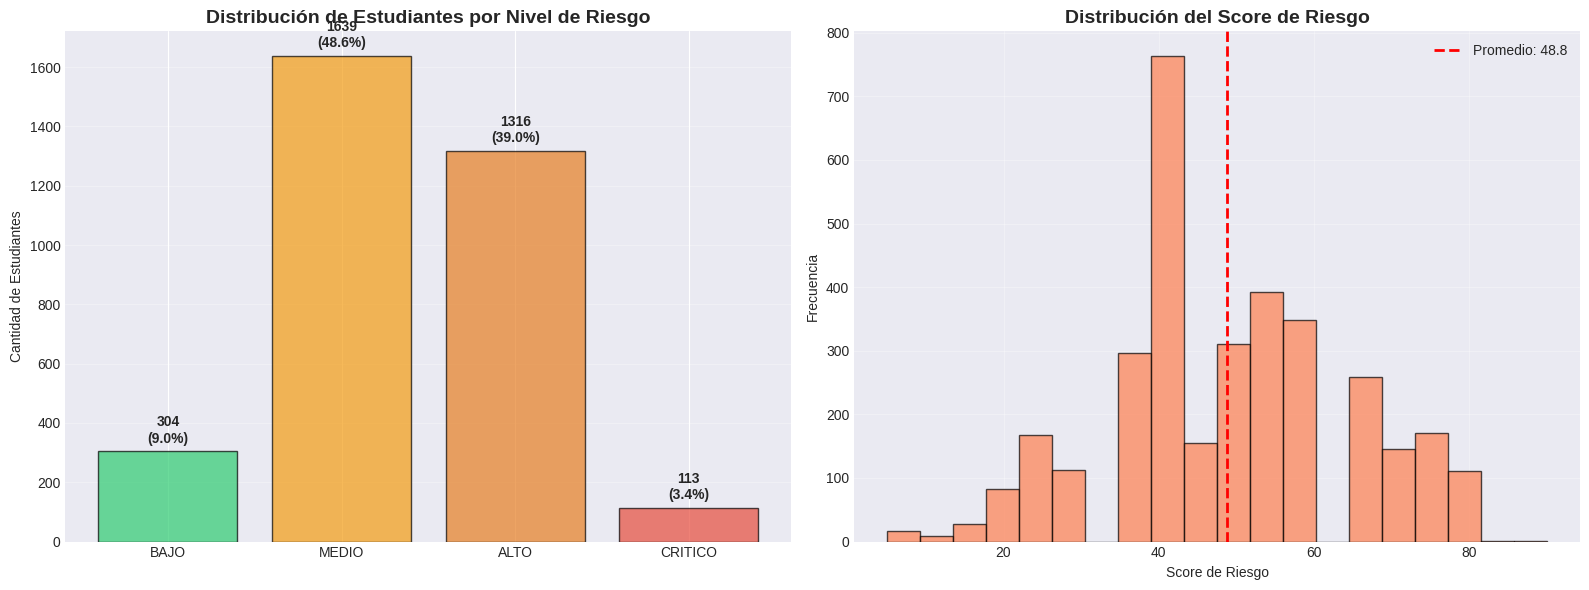

✓ Gráfico guardado: reports/figures/bi_nivel_riesgo_distribucion.png


In [13]:
# Gráfico de distribución de nivel de riesgo
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Distribución de nivel de riesgo
nivel_riesgo_counts = fact_desercion['nivel_riesgo'].value_counts().sort_index()
colors_riesgo = {'BAJO': '#2ecc71', 'MEDIO': '#f39c12', 'ALTO': '#e67e22', 'CRITICO': '#e74c3c'}
colors = [colors_riesgo.get(nivel, 'gray') for nivel in nivel_riesgo_counts.index]

bars = axes[0].bar(range(len(nivel_riesgo_counts)), nivel_riesgo_counts.values, 
                   color=colors, edgecolor='black', alpha=0.7)
axes[0].set_xticks(range(len(nivel_riesgo_counts)))
axes[0].set_xticklabels(nivel_riesgo_counts.index, rotation=0)
axes[0].set_ylabel('Cantidad de Estudiantes')
axes[0].set_title('Distribución de Estudiantes por Nivel de Riesgo', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Añadir valores
for i, val in enumerate(nivel_riesgo_counts.values):
    pct = (val / nivel_riesgo_counts.sum()) * 100
    axes[0].text(i, val + 20, f'{val}\n({pct:.1f}%)', ha='center', va='bottom', fontweight='bold')

# Gráfico 2: Distribución de score de riesgo
axes[1].hist(fact_desercion['score_riesgo'], bins=20, color='coral', edgecolor='black', alpha=0.7)
axes[1].axvline(fact_desercion['score_riesgo'].mean(), color='red', linestyle='--', 
               linewidth=2, label=f'Promedio: {fact_desercion["score_riesgo"].mean():.1f}')
axes[1].set_xlabel('Score de Riesgo')
axes[1].set_ylabel('Frecuencia')
axes[1].set_title('Distribución del Score de Riesgo', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/bi_nivel_riesgo_distribucion.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Gráfico guardado: reports/figures/bi_nivel_riesgo_distribucion.png")

## 7. Guardar Modelo Dimensional

In [14]:
# Guardar todas las tablas del modelo
print("=" * 70)
print("GUARDANDO MODELO DIMENSIONAL")
print("=" * 70)

# Crear directorio si no existe
os.makedirs('../data/bi', exist_ok=True)

# Guardar cada tabla
dim_tiempo.to_csv('../data/bi/dim_tiempo.csv', index=False)
print("✓ Guardado: data/bi/dim_tiempo.csv")

dim_estudiante.to_csv('../data/bi/dim_estudiante.csv', index=False)
print("✓ Guardado: data/bi/dim_estudiante.csv")

dim_programa.to_csv('../data/bi/dim_programa.csv', index=False)
print("✓ Guardado: data/bi/dim_programa.csv")

dim_institucion.to_csv('../data/bi/dim_institucion.csv', index=False)
print("✓ Guardado: data/bi/dim_institucion.csv")

fact_desercion.to_csv('../data/bi/fact_desercion.csv', index=False)
print("✓ Guardado: data/bi/fact_desercion.csv")

# Guardar KPIs calculados
kpis_resumen = pd.DataFrame({
    'KPI': [
        'Total Desertores',
        'Score Promedio Riesgo',
        '% Alto Riesgo',
        'Estudiantes Alto Riesgo'
    ],
    'Valor': [
        kpi_total_desertores,
        round(kpi_score_promedio, 2),
        round(kpi_pct_alto_riesgo, 2),
        estudiantes_alto_riesgo
    ]
})

kpis_resumen.to_csv('../data/bi/kpis_principales.csv', index=False)
print("✓ Guardado: data/bi/kpis_principales.csv")

print("\n" + "=" * 70)
print("✅ MODELO DIMENSIONAL GUARDADO EXITOSAMENTE")
print("=" * 70)

GUARDANDO MODELO DIMENSIONAL
✓ Guardado: data/bi/dim_tiempo.csv
✓ Guardado: data/bi/dim_estudiante.csv
✓ Guardado: data/bi/dim_programa.csv
✓ Guardado: data/bi/dim_institucion.csv
✓ Guardado: data/bi/fact_desercion.csv
✓ Guardado: data/bi/kpis_principales.csv

✅ MODELO DIMENSIONAL GUARDADO EXITOSAMENTE


## 8. Resumen del Diseño de BI

In [15]:
print("=" * 70)
print("RESUMEN DEL DISEÑO DE BUSINESS INTELLIGENCE")
print("=" * 70)

print("\n📐 ARQUITECTURA DEL MODELO:")
print("   • Tipo: Modelo Dimensional Estrella")
print("   • Tabla de Hechos: 1 (FACT_DESERCION)")
print("   • Tablas de Dimensiones: 4")
print("     - DIM_TIEMPO")
print("     - DIM_ESTUDIANTE")
print("     - DIM_PROGRAMA")
print("     - DIM_INSTITUCION")

print("\n📊 MÉTRICAS IMPLEMENTADAS:")
print("   • Total de Desertores")
print("   • Score de Riesgo (0-100)")
print("   • Nivel de Riesgo (Bajo/Medio/Alto/Crítico)")
print("   • Tipo de Deserción (Académica/No Académica)")
print("   • KPIs por Dimensiones (edad, estrato, etc.)")

print("\n🎯 REGLAS DE NEGOCIO APLICADAS:")
print("   • Clasificación de tasa de deserción")
print("   • Cálculo de score de riesgo multifactorial")
print("   • Categorización de estudiantes vulnerables")
print("   • Identificación de factores de riesgo")

print("\n💾 ARCHIVOS GENERADOS:")
print("   • 5 Tablas del modelo dimensional (CSV)")
print("   • 1 Archivo de KPIs principales")
print("   • 1 Visualización de distribución de riesgo")

print("\n✅ VENTAJAS DEL MODELO DISEÑADO:")
print("   • Consultas rápidas y eficientes")
print("   • Fácil de entender y mantener")
print("   • Escalable para más datos")
print("   • Listo para herramientas de BI (Power BI, Tableau, etc.)")
print("   • Soporta análisis multidimensional")

print("\n" + "=" * 70)
print("✅ DISEÑO DE BI COMPLETADO EXITOSAMENTE")
print("=" * 70)
print("\n🎯 PRÓXIMO PASO: Ejecutar notebook 04_Dashboard.ipynb para crear dashboard interactivo")

RESUMEN DEL DISEÑO DE BUSINESS INTELLIGENCE

📐 ARQUITECTURA DEL MODELO:
   • Tipo: Modelo Dimensional Estrella
   • Tabla de Hechos: 1 (FACT_DESERCION)
   • Tablas de Dimensiones: 4
     - DIM_TIEMPO
     - DIM_ESTUDIANTE
     - DIM_PROGRAMA
     - DIM_INSTITUCION

📊 MÉTRICAS IMPLEMENTADAS:
   • Total de Desertores
   • Score de Riesgo (0-100)
   • Nivel de Riesgo (Bajo/Medio/Alto/Crítico)
   • Tipo de Deserción (Académica/No Académica)
   • KPIs por Dimensiones (edad, estrato, etc.)

🎯 REGLAS DE NEGOCIO APLICADAS:
   • Clasificación de tasa de deserción
   • Cálculo de score de riesgo multifactorial
   • Categorización de estudiantes vulnerables
   • Identificación de factores de riesgo

💾 ARCHIVOS GENERADOS:
   • 5 Tablas del modelo dimensional (CSV)
   • 1 Archivo de KPIs principales
   • 1 Visualización de distribución de riesgo

✅ VENTAJAS DEL MODELO DISEÑADO:
   • Consultas rápidas y eficientes
   • Fácil de entender y mantener
   • Escalable para más datos
   • Listo para herram

---

## Fin del Notebook BI Design

**Modelo dimensional creado:**
- ✅ Esquema estrella implementado
- ✅ 4 dimensiones definidas
- ✅ 1 tabla de hechos con métricas
- ✅ KPIs principales calculados
- ✅ Reglas de negocio aplicadas
- ✅ Score de riesgo implementado

**Datos listos para:**
- 📊 Dashboard interactivo (Plotly Dash)
- 📈 Herramientas de BI (Power BI, Tableau)
- 🤖 Integración con modelo predictivo

**Archivos generados en `data/bi/`:**
- `dim_tiempo.csv`
- `dim_estudiante.csv`
- `dim_programa.csv`
- `dim_institucion.csv`
- `fact_desercion.csv`
- `kpis_principales.csv`

---